#### 0.载入包和初始化

In [14]:
import pandas as pd
import random
import ast
import csv
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('using gpu: %s' % torch.cuda.is_available())
isgpu = torch.cuda.is_available()

using gpu: True


#### 1.读取处理后的数据

In [15]:
#读取训练集和测试集
x_set = []
y_set = []
trail_set =[]
trail_set_test =[]

root_path = 'C:/GitHub/FSNet/1.code'

df = pd.read_csv(root_path + '/output_fs_human.csv')
for index , row in df.iterrows():
    list_x = ast.literal_eval(row[0])
    list_y = ast.literal_eval(row[1])
    trail_set.append((list_x,list_y))
    
df_test = pd.read_csv(root_path + '/output_fs_human_test.csv')
for index , row in df.iterrows():
    list_x = ast.literal_eval(row[0])
    list_y = ast.literal_eval(row[1])
    trail_set_test.append((list_x,list_y))

C:\Users\Sengoku\AppData\Local\Temp\ipykernel_36312\3827082472.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_x = ast.literal_eval(row[0])
C:\Users\Sengoku\AppData\Local\Temp\ipykernel_36312\3827082472.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_y = ast.literal_eval(row[1])
C:\Users\Sengoku\AppData\Local\Temp\ipykernel_36312\3827082472.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_x = ast.literal

#### 2.定义神经网络

In [16]:
train_num = 100
thresholds = 0.8
check_point = 21

loss_ther = 0.03

train_correct_list = []
train_sk_list = []
train_fs_list = []
train_match_list = []
train_mis_list = []
train_rt_list = []

In [17]:
activity_dict = []
trial_infos = []
#定义神经网络模型

class rnnNet(nn.Module):
    def __init__(self):
        super(rnnNet, self).__init__()
        # self.rnn = CTRNN(input_size = 2, hidden_size = 32)
        self.rnn = nn.RNN(input_size = 2, hidden_size = 32)
        # self.rnn = RNN(input_size = 2, hidden_size = 32)
        self.fc = nn.Linear(32,2)
        self.relu = nn.ReLU()
          
        for name, param in self.rnn.named_parameters():
            if name.startswith("weight"):
                nn.init.xavier_normal_(param)
            else:
                nn.init.zeros_(param)

    def forward(self, x):
        neuro_act, h = self.rnn(x, None)
        # print(neuro_act.size())
        out = self.relu(neuro_act)
        out = self.fc(out)
        return out , neuro_act
    
model = rnnNet().to(device)

#### 3.训练神经网络

In [18]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025) 
running_loss = 0
u = 0.5
sigma = 0.1
total = 0
loss_report = 100
loss_list = []
stimulus_num = len(x_set)
i = 0

num_epochs = 500
avg_loss = 1
min_loss = 1

for epoch in range(num_epochs):
    if avg_loss < loss_ther:
        print('break_out')
        break

    for trail in enumerate(trail_set):
        input_stimul = torch.tensor(trail[1][0])
        labels = torch.tensor(trail[1][1])   
             
        optimizer.zero_grad()
        input_channel = input_stimul
        # print(input_channel.size())
        outputs, neuro_act = model(input_channel.to(device))
        

        loss = criterion(outputs,labels.to(device))
        loss.backward()
        optimizer.step()
        
        running_loss +=loss.item()
        total +=running_loss
        i +=1
        if i %loss_report == 0:
            avg_loss = float(total/loss_report)
            print("step[{}]  loss:{:.4f}".format(i+1,avg_loss))
            loss_list.append(avg_loss)
            total = 0
            if avg_loss < min_loss:
                min_loss = avg_loss
            if avg_loss < loss_ther:
                print('break')
                break
        running_loss = 0
        activity_dict.append(neuro_act.cpu().detach().numpy())
        trial_infos.append(labels[check_point][1])

step[101]  loss:0.1392
step[201]  loss:0.1183
step[301]  loss:0.1133
step[401]  loss:0.1105
step[501]  loss:0.1094
step[601]  loss:0.1088
step[701]  loss:0.1090
step[801]  loss:0.1020
step[901]  loss:0.1042
step[1001]  loss:0.1030
step[1101]  loss:0.1007
step[1201]  loss:0.1011
step[1301]  loss:0.0944
step[1401]  loss:0.0920
step[1501]  loss:0.0920
step[1601]  loss:0.0797
step[1701]  loss:0.0872
step[1801]  loss:0.0815
step[1901]  loss:0.0814
step[2001]  loss:0.0727
step[2101]  loss:0.0679
step[2201]  loss:0.0605
step[2301]  loss:0.0588
step[2401]  loss:0.0658
step[2501]  loss:0.0574
step[2601]  loss:0.0482
step[2701]  loss:0.0540
step[2801]  loss:0.0559
step[2901]  loss:0.0621
step[3001]  loss:0.0627
step[3101]  loss:0.0472
step[3201]  loss:0.0581
step[3301]  loss:0.0531
step[3401]  loss:0.0425
step[3501]  loss:0.0486
step[3601]  loss:0.0649
step[3701]  loss:0.0508
step[3801]  loss:0.0473
step[3901]  loss:0.0477
step[4001]  loss:0.0466
step[4101]  loss:0.0452
step[4201]  loss:0.0330
s

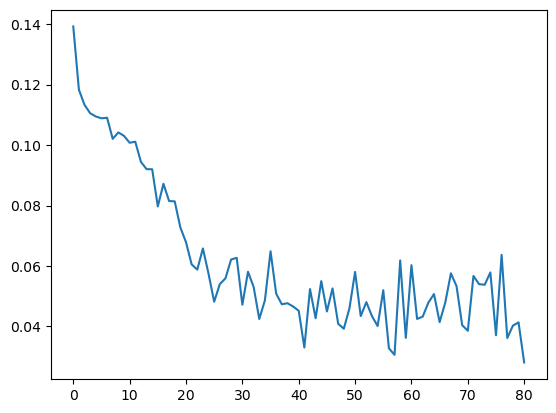

In [19]:
#打印loss图
plt.plot(loss_list)
plt.show()

##### 保存和读取训练好的模型

In [20]:
# model = torch.load(root_path+'/model_PCA_512_05122103.pth')

In [21]:
import time
current_time = time.strftime("%m%d%H%M", time.localtime())
torch.save(model, 'model_PCA_512_'+current_time+'.pth')

#### 4.测试模型

In [22]:
#测试部分

thresholds = 0.75

correct = 0
num = 0
match_timelist = []
mismatch_timelist = []
choice = 0
react_timepoint = 0
label_rt = []
output_rt = []
activity_dict = []
trial_infos = []
i = 0
for trail in enumerate(trail_set_test):
    #生成数据
    input_stimul = torch.tensor(trail[1][0])
    labels = torch.tensor(trail[1][1])
    input_channel = input_stimul  
    if i == 72:
        break
    i +=1
    #输入网络
    outputs ,neuro_act = model(input_channel.to(device))

    outputs_number = outputs.cpu().detach().numpy()
    labels_number = labels.cpu().detach().numpy()
    for j in range(len(outputs_number)):
        if (outputs_number[j][0] > thresholds):
            react_timepoint = j-1+(thresholds-outputs_number[j-1][0])/(outputs_number[j][0]-outputs_number[j-1][0])
            #mis
            # plt.plot(outputs_number, color = 'blue',alpha = 0.001)
            mismatch_timelist.append(react_timepoint)
            choice = 0
            break
        if (outputs_number[j][1] > thresholds):
            react_timepoint = j-1+(thresholds-outputs_number[j-1][1])/(outputs_number[j][1]-outputs_number[j-1][1])
            #match
            # plt.plot(outputs_number, color = 'red',alpha = 0.001)
            match_timelist.append(react_timepoint)
            choice = 1
            break
    # plt.plot(labels_number, color = 'black',alpha = 0.001)
    output_rt.append(react_timepoint)
    num +=1
    if choice == labels[check_point][1]:
        correct+=1

    activity_dict.append(neuro_act.cpu().detach().numpy())
    trial_infos.append(choice)
    
match_mean = np.mean(match_timelist)
mismatch_mean = np.mean(mismatch_timelist)

#输出匹配和不匹配试次的平均反应时（原始数据）
print(np.mean(match_timelist))
print(np.mean(mismatch_timelist))

14.071617605604173
14.09063415600553


#### 5.模型分析——PCA

[3.5794228e-01 2.1159026e-01 1.0281206e-01 9.5458761e-02 7.1720533e-02
 4.0500499e-02 3.1142037e-02 2.2066843e-02 2.0435326e-02 1.1861216e-02
 8.9868559e-03 5.5820062e-03 4.6546794e-03 2.8958251e-03 1.9978117e-03
 1.7552257e-03 1.4382628e-03 1.3234793e-03 1.1413943e-03 8.5807027e-04
 6.7276775e-04 5.6705752e-04 5.3449947e-04 4.3225102e-04 3.1983198e-04
 2.7827531e-04 2.5278045e-04 2.2884610e-04 1.8330626e-04 1.4682491e-04
 1.4513564e-04 7.4961150e-05]
[0.35794228 0.5695325  0.67234457 0.7678033  0.83952385 0.8800244
 0.9111664  0.93323326 0.9536686  0.9655298 ]


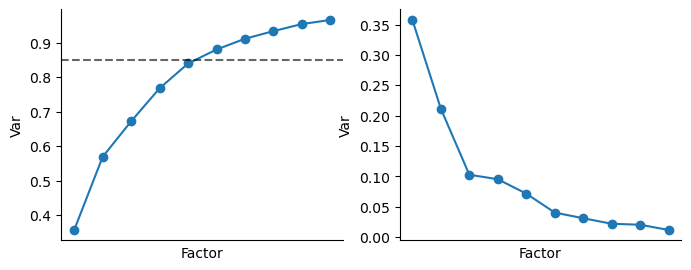

Text(0, 0.5, 'PC 2')

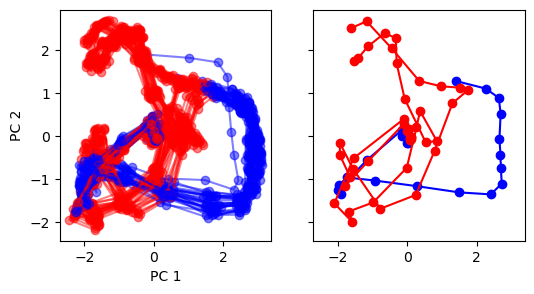

In [23]:
activity = np.concatenate(list(activity_dict[i] for i in range(72)), axis=0)
pca = PCA(n_components=5)
pca.fit(activity)
iris_line = PCA().fit(activity)
iris_line.explained_variance_ratio_
print(iris_line.explained_variance_ratio_)
print(np.cumsum(iris_line.explained_variance_ratio_)[0:10])

fig, ax = plt.subplots(1,2)
#设置图表尺寸，单位：像素
fig.set_size_inches(8, 3)

ax[0].plot(np.cumsum(iris_line.explained_variance_ratio_)[0:10],'-o')
ax[0].set_xticks(())
ax[0].set_xlabel('Factor')
ax[0].set_ylabel('Var')
ax[1].plot(iris_line.explained_variance_ratio_[0:10],'-o')
ax[1].set_xticks(())
ax[1].set_xlabel('Factor')
ax[1].set_ylabel('Var')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].axhline(0.85, linestyle='--',color = 'black',alpha =0.6)
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(72):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial == 0 else 'blue'
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color,alpha =0.5)
    
    if i < 3:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

match_choice_var:3.5818798295382797,mismatch_choice_var:1.088321445986282
match_stimu_var:0.6806055184068351,mismatch_stimu_var:0.6796526659366696
0.03478497 0.06255057
match_choice_var:0.7187274684166086,mismatch_choice_var:1.9778652440669924
match_stimu_var:0.3386164865103261,mismatch_stimu_var:0.35223744333136914
0.09371611 0.07943828
match_choice_var:0.24837515683009706,mismatch_choice_var:1.0778715513473334
match_stimu_var:0.1025421278840252,mismatch_stimu_var:0.26971264540889234
0.048595265 0.60549325


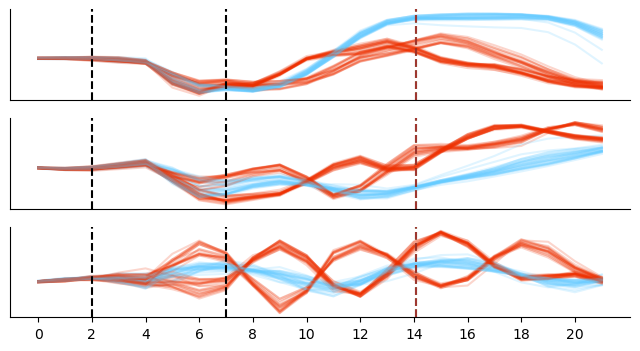

In [24]:

fig, ax = plt.subplots(3,1)
#设置图表尺寸，单位：像素
fig.set_size_inches(8, 4)

Factors = {0,1,2}

fc_var_set_match = [[],[],[]]
fc_var_set_mismatch = [[],[],[]]

var_match = 0
var_mismatch = 0

for fac in Factors:
    var_match_choice = 0
    num_match = 0
    var_match_stimu = 0
    
    var_mismatch_choice = 0
    num_miamatch = 0
    var_mismatch_stimu = 0
    
    activity_pc[:, fac]
    
    for i in range(72):
        activity_pc = pca.transform(activity_dict[i])
        trial = trial_infos[i]
        color = '#ee3000' if trial == 0 else '#66ccff'
        # if trial == 0:
        ax[fac].plot(activity_pc[:, fac],color = color,alpha = 0.2)
            # print("1")
        
        
        
        if trial == 1:
            #计算activity_pc[:, fac]的方差
            var_match_choice += np.var(activity_pc[7:22, fac])
            var_match_stimu += np.var(activity_pc[2:7, fac])
            num_match += 1
            
            fc_var_set_match[fac].append(activity_pc[4:8, fac])
            
        else:
            var_mismatch_choice += np.var(activity_pc[7:22, fac])
            var_mismatch_stimu += np.var(activity_pc[2:7, fac])
            num_miamatch += 1
            
            fc_var_set_mismatch[fac].append(activity_pc[4:7, fac])
    print("match_choice_var:{},mismatch_choice_var:{}".format(var_match_choice/num_match,var_mismatch_choice/num_miamatch))
    print("match_stimu_var:{},mismatch_stimu_var:{}".format(var_match_stimu/num_match,var_mismatch_stimu/num_miamatch))
    

    fc_var_set_match[fac] = pd.DataFrame(fc_var_set_match[fac])
    var_match = fc_var_set_match[fac].var()
    var_match = np.mean(var_match)
        
    fc_var_set_mismatch[fac] = pd.DataFrame(fc_var_set_mismatch[fac])
    # for fac_var in fc_var_set_mismatch[fac].columns:
    #     var_mismatch += fac_var.var()
    var_mismatch = fc_var_set_mismatch[fac].var()
    var_mismatch = np.mean(var_mismatch)
        
    print(var_match,var_mismatch)
    
    ax[fac].spines['top'].set_visible(False)
    ax[fac].spines['right'].set_visible(False)
    
    ax[fac].set_yticks(())
    ax[fac].set_xticks(())
    if fac == 2:
        ax[fac].set_xticks(range(0,21,2)) 
    ax[fac].axvline(match_mean, linestyle='--',color = 'green',alpha =0.6)   
    ax[fac].axvline(mismatch_mean, linestyle='--',color = 'brown',alpha =0.9)  
    
    ax[fac].axvline(2, linestyle='--',color = 'black',alpha =1)
    ax[fac].axvline(7, linestyle='--',color = 'black',alpha =1)
    
# plt.legend(["mismatch","match"],bbox_to_anchor=(1.15, 3.2), frameon=False)
plt.show()



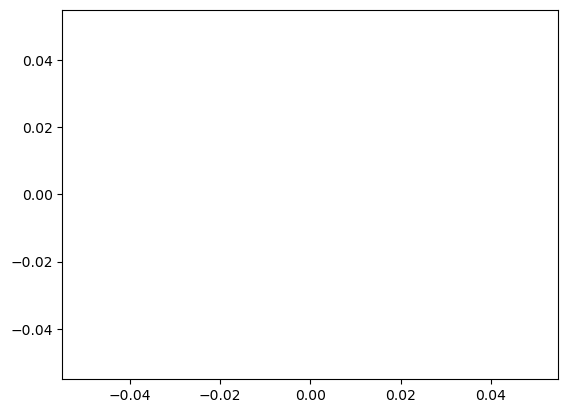

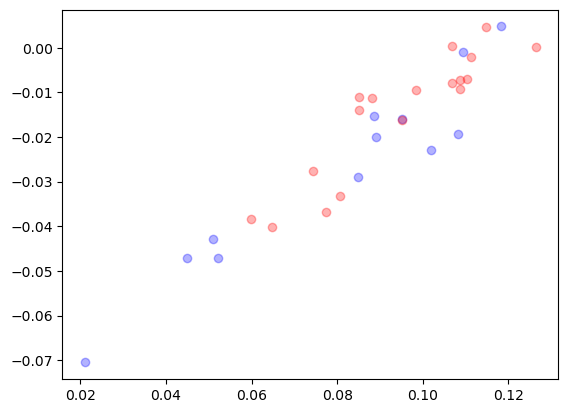

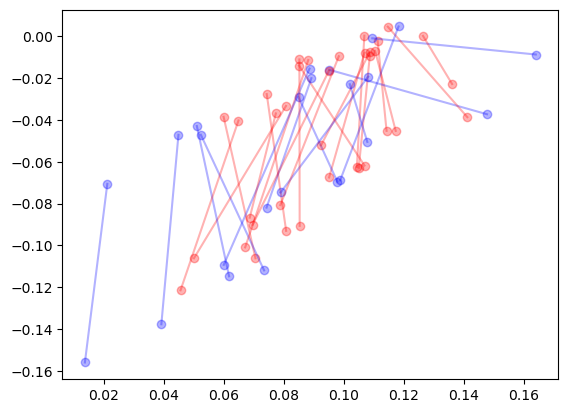

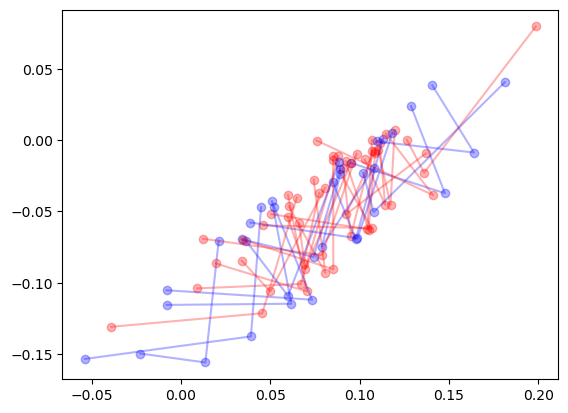

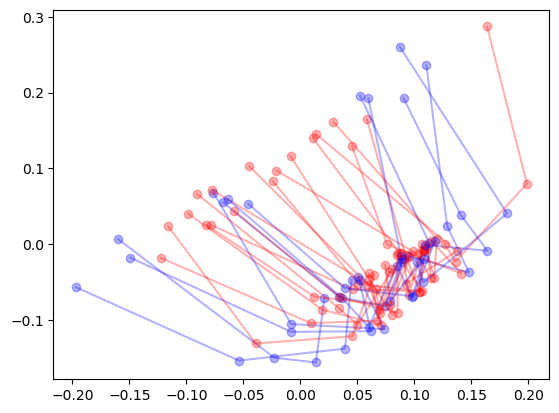

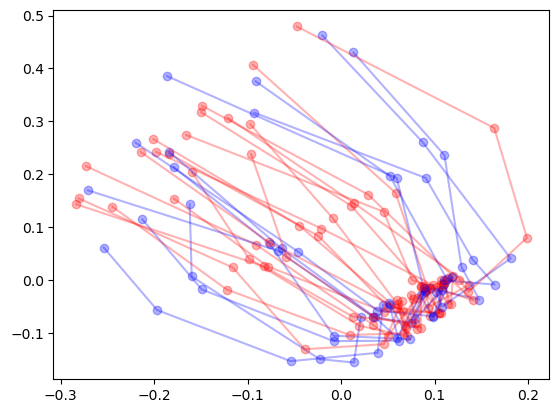

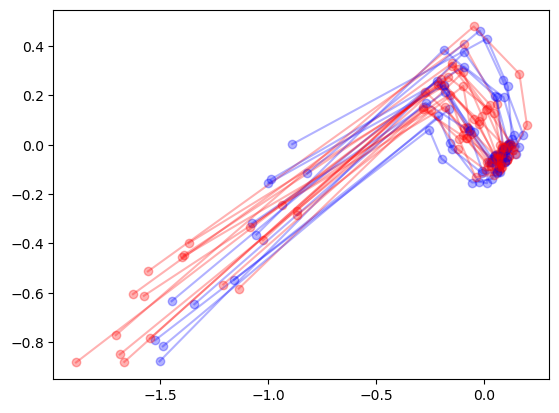

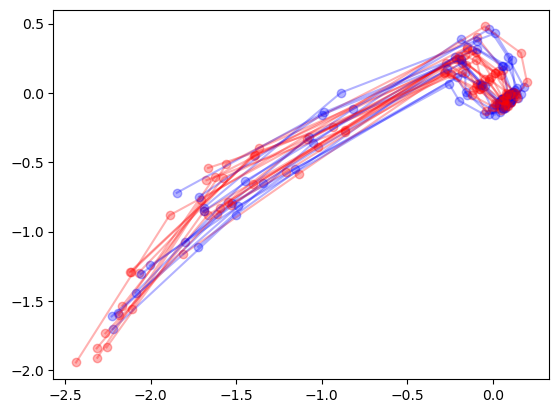

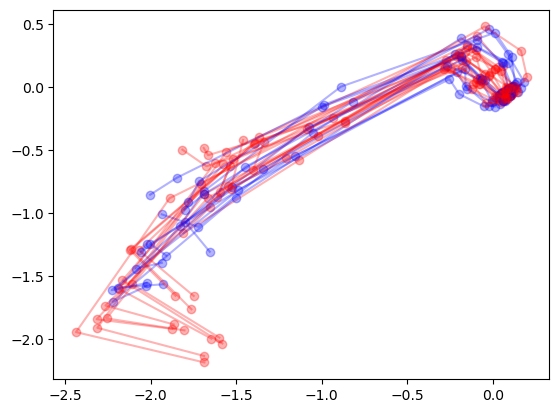

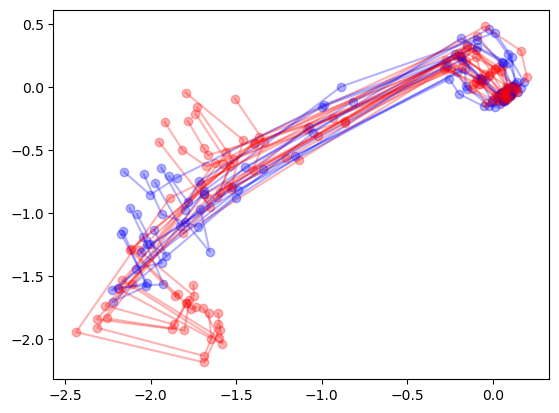

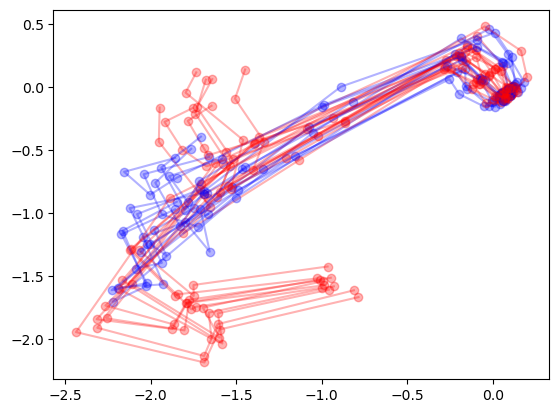

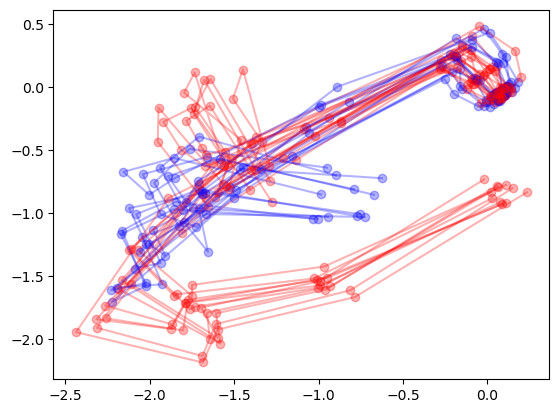

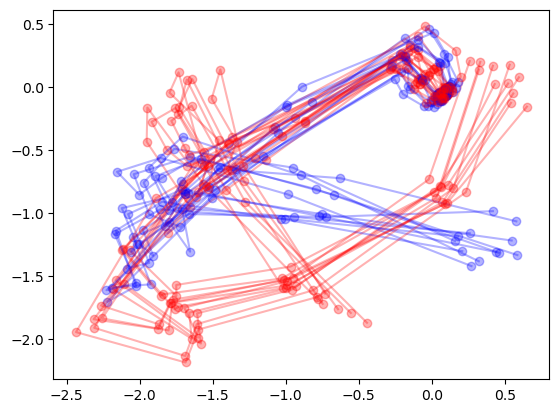

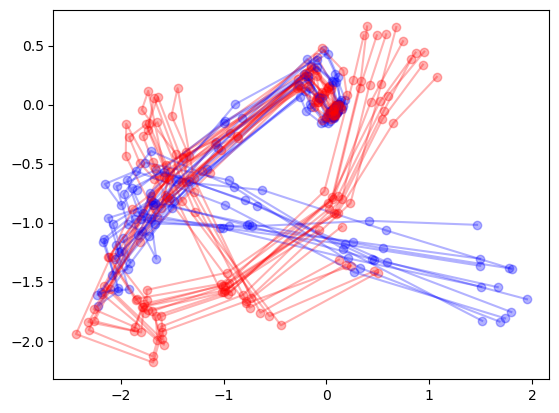

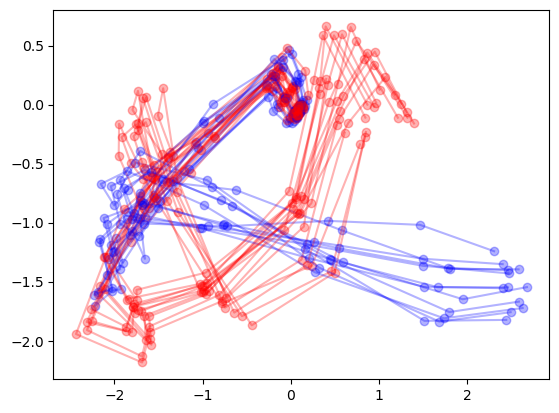

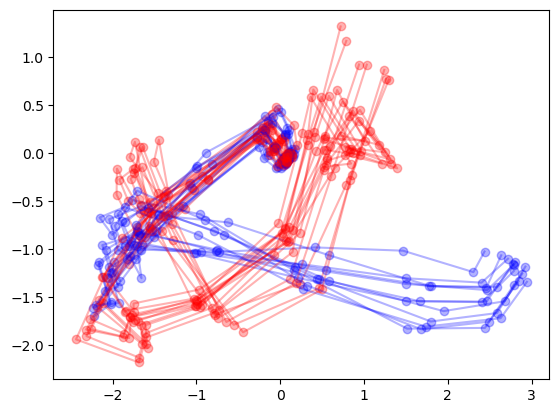

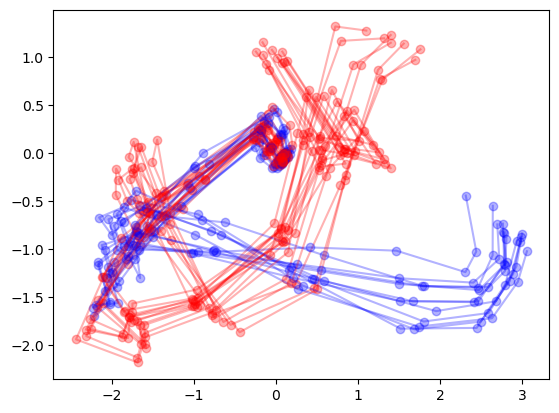

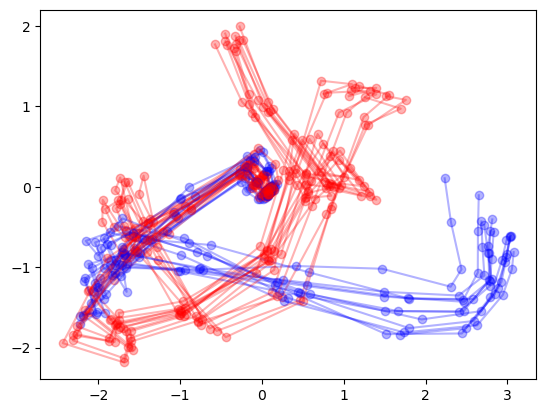

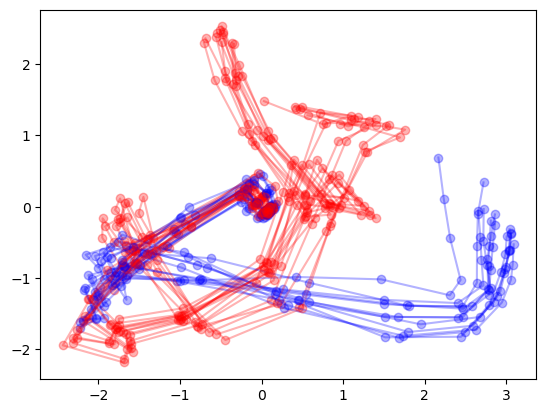

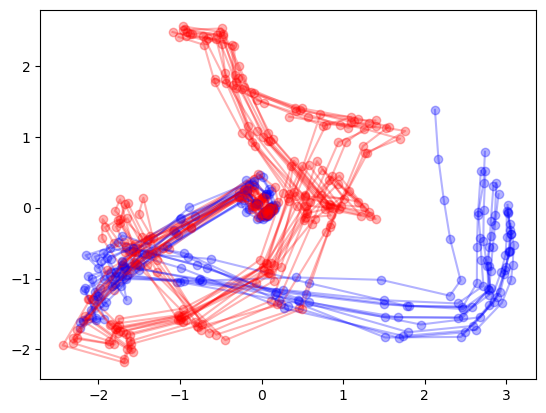

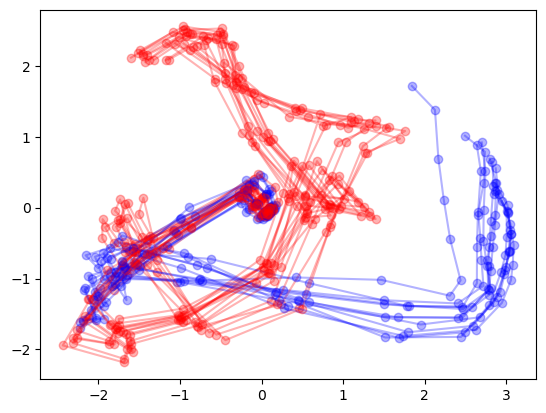

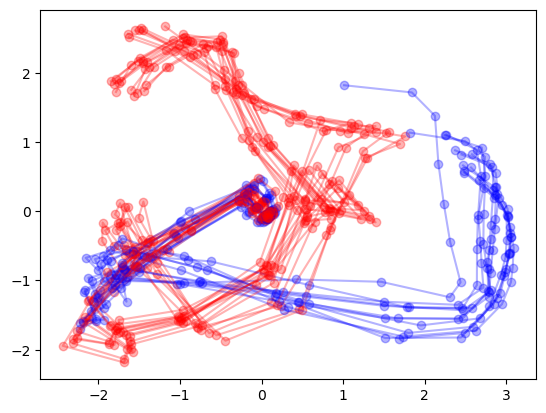

In [25]:
plt.figure()
for end in range(22) :
    for i in range(30):
        activity_pc = pca.transform(activity_dict[i])
        trial = trial_infos[i]
        color = 'red' if trial == 0 else 'blue'
        plt.plot(activity_pc[0:end, 0], activity_pc[0:end, 1], 'o-', color=color,alpha = 0.3)
    plt.show()

